In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from KeystrokeAnomalyDetector import KeystrokeAnomalyDetector

In [2]:
DATASET_PATH = '/content/DSL-StrongPasswordData.csv'

def show_report(model_name, res):
    accuracy = res['accuracy']
    eer = res['eer']
    auc = res['roc_auc']
    zm_far = res['zmfar']
    tpr = res['tpr']
    fpr = res['fpr']
    conf_matrix = res['conf_matrix']

    print(
        f"--> {model_name} <--\n"
        f"Accuracy: {(accuracy):.2f}\n"
        f"AUC: {(auc):.2f}\n"
        f"EER: {(eer*100):.2f} %\n"
        f"TPR: {(tpr*100):.2f} %\n"
        f"FPR: {(fpr*100):.2f} %\n"
        f"Confusion matrix:\n{conf_matrix}\n"
        f"--------------------------\n"
    )

In [ ]:
impostors = [f's00{i}' for i in range (3, 10, 1)]
impostors.extend(
    [f's0{i}' for i in range (10, 58, 1)]
)

# Init detectors
detector1 = KeystrokeAnomalyDetector(
    model_name='KNN',
    model_params={'n_neighbors': 3, 'p': 1},
    scaler_enabled=False
)
detector2 = KeystrokeAnomalyDetector(
    model_name='IsolationForest',
    model_params={'n_estimators': 90},
    scaler_enabled=False
)
detector3 = KeystrokeAnomalyDetector(
    model_name='OneClassSVM',
    model_params={'nu': 0.4},
    scaler_enabled=False
)
detector4 = KeystrokeAnomalyDetector(
    model_name='LOF',
    model_params={'n_neighbors': 5, 'p': 1},
    scaler_enabled=False
)

n_legit = [50, 100, 200]
n_impostors_each = [1, 2, 4]
reports = []

In [4]:
for legit, impostors_each in zip(n_legit, n_impostors_each):
    # KNN
    detector1.run_pipeline(
        extractor_path=DATASET_PATH,
        target_subject='s002',
        impostors=impostors,
        n_test_legit=legit,
        n_test_impostors_each=impostors_each
    )

    # Isolation Forest
    detector2.run_pipeline(
        extractor_path=DATASET_PATH,
        target_subject='s002',
        impostors=impostors,
        n_test_legit=legit,
        n_test_impostors_each=impostors_each
    )

    # One-Class SVM
    detector3.run_pipeline(
        extractor_path=DATASET_PATH,
        target_subject='s002',
        impostors=impostors,
        n_test_legit=legit,
        n_test_impostors_each=impostors_each
    )

    # LOF
    detector4.run_pipeline(
        extractor_path=DATASET_PATH,
        target_subject='s002',
        impostors=impostors,
        n_test_legit=legit,
        n_test_impostors_each=impostors_each
    )

    reports.append([
        detector1.get_report(),
        detector2.get_report(),
        detector3.get_report(),
        detector4.get_report()
    ])


==== 50 legit, 50 impostors ====
           Model  Accuracy  AUC (%)  EER (%)  TPR (%)  FPR (%)
             KNN      0.71    93.96     15.0     84.0     14.0
Isolation Forest      0.90    94.88     13.0     86.0     12.0
   One-Class SVM      0.54    89.04     19.0     84.0     22.0
             LOF      0.85    95.24     11.0     88.0     10.0


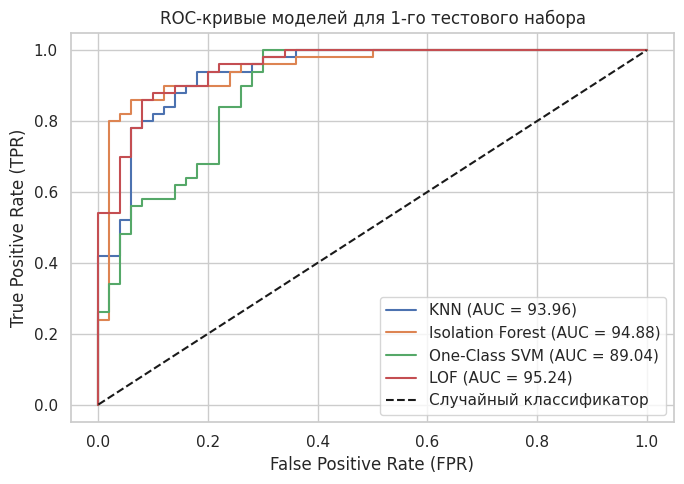


==== 100 legit, 100 impostors ====
           Model  Accuracy  AUC (%)  EER (%)  TPR (%)  FPR (%)
             KNN     0.665    91.50     14.5     87.0     16.0
Isolation Forest     0.860    92.28     13.5     86.0     13.0
   One-Class SVM     0.520    78.02     29.0     71.0     29.0
             LOF     0.760    91.54     15.0     86.0     16.0


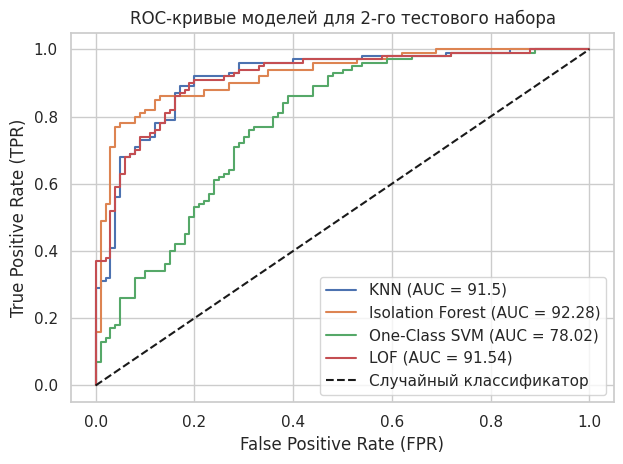


==== 200 legit, 200 impostors ====
           Model  Accuracy  AUC (%)  EER (%)  TPR (%)  FPR (%)
             KNN     0.590   81.753    26.75     73.5     27.0
Isolation Forest     0.785   87.578    21.50     78.5     21.5
   One-Class SVM     0.507   62.992    44.25     55.5     44.0
             LOF     0.632   80.219    28.00     72.0     28.0


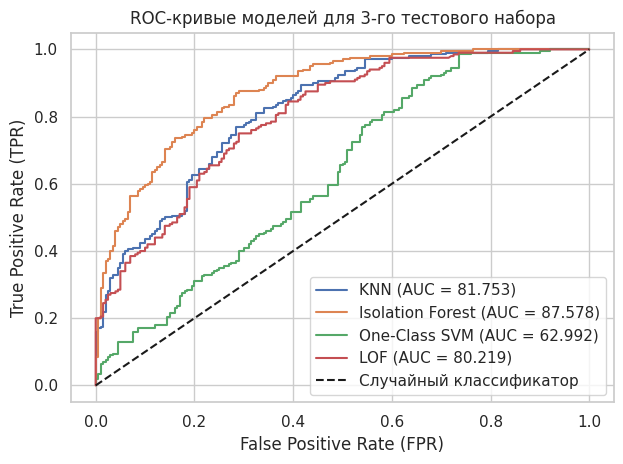

In [19]:
models = ["KNN", "Isolation Forest", "One-Class SVM", "LOF"]
plt.figure(figsize=(7, 5))

for i, (report_set, legit, impostors_each) in enumerate(zip(reports, n_legit, n_impostors_each)):
    print(f"\n==== {legit} legit, {impostors_each * 50} impostors ====")

    table_data = {
        "Model": models,
        "Accuracy": [round(r["accuracy"], 3) for r in report_set],
        "AUC (%)": [round(r["roc_auc"] * 100, 3) for r in report_set],
        "EER (%)": [round(r["eer"] * 100, 2) for r in report_set],
        "TPR (%)": [round(r["tpr"] * 100, 1) for r in report_set],
        "FPR (%)": [round(r["fpr"] * 100, 1) for r in report_set]
    }

    df = pd.DataFrame(table_data)
    print(df.to_string(index=False))

    for r, model in zip(report_set, models):
        plt.plot(r["fpr_list"], r["tpr_list"], label=f'{model} (AUC = {round(r["roc_auc"] * 100, 3)})')

    plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC-кривые моделей для {i + 1}-го тестового набора')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()